# The Validation Pipeline
## Imports
The sklearn package is needed for evaluation:
```
pip install scikit-learn
```
If possible, it definitely makes sense to use your GPU for predictions.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math

from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Check GPU
print(tf.test.is_built_with_cuda())

True


# Load model and import data
All good model iterations are stored in trained_models folder by version and accuracy.
If a unsorted dataset/directory (e.g. Test dataset) is imported, use_test_data musst be set to True!

In [40]:
# ===== Choose model =====
model_name = "v1_vacc_0.9585"
# model_name = "v2_vacc_0.8186"

import_path = "./trained_models/{}".format(str(model_name))
model = tf.keras.models.load_model(import_path)

# ===== Load validation data =====
use_test_data = False # Set to false if other validation batch data is used
use_augmented_ds = False # Is Set to true if data augmentation cell (see below) is run
batch_nr = 2
if use_test_data:
    test_data_root = "./dataset/Test"
elif use_augmented_ds:
    # test_data_root = "./dataset/ValidationAug/"
    test_data_root = "./Validation/ValidationAug/"  # unzip Validation folder to DeepSafety directory
else:
    # test_data_root = "./safetyBatches/Batch_" + str(batch_nr) + "/"
    # test_data_root = "./dataset/Validation/"
    test_data_root = "./Validation/Validation/"   # unzip Validation folder to DeepSafety directory
train_data_root = "./dataset/Train"

batch_size = 32
img_height = 224
img_width = 224
# img_height = 96
# img_width = 96

train_ds = tf.keras.utils.image_dataset_from_directory(train_data_root + '/')
# Get information on your train classes
train_class_names = np.array(train_ds.class_names)
print("Train Classes available: ", train_class_names)

# Import labels: (Test dataset is unsorted)
train_csv_path = train_data_root + '_label.csv'
train_df = pd.read_csv(filepath_or_buffer=train_csv_path, delimiter=',')
train_labels = train_df['ClassId'].tolist()
if use_test_data: # Directory without class structure/sub folders
    test_csv_path = test_data_root + '_label.csv'
    test_df = pd.read_csv(filepath_or_buffer=test_csv_path, delimiter=',')
    test_labels = test_df['ClassId'].tolist()

    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory=test_data_root + '/',
        labels=test_labels,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=False,
    )

else:  # Directory with class structure/sub folders
    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory=test_data_root,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=False,
    )

files = test_ds.file_paths

# Get information on your val classes
class_names = np.array(test_ds.class_names)
print("Val Classes available: ", class_names)

if not use_test_data:
    # get the ground truth labels
    test_labels = np.concatenate([y for x, y in test_ds], axis=0)
    # Mapping test labels to the folder names instead of the index
    for i in range(0, len(test_labels)):
        test_labels[i] = int(class_names[test_labels[i]])
else:
    test_labels = test_labels


Found 39209 files belonging to 43 classes.
Train Classes available:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
Found 12802 files belonging to 43 classes.
Val Classes available:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']


# Validation dataset/batch analysis
Below, the histograms per class for the amount of labels and the amount of signs is plotted. Considering that every sign is captured for 30 frames some signs are really rare represented!

In [34]:
train_class_names_int = [int(cls) for cls in train_class_names]

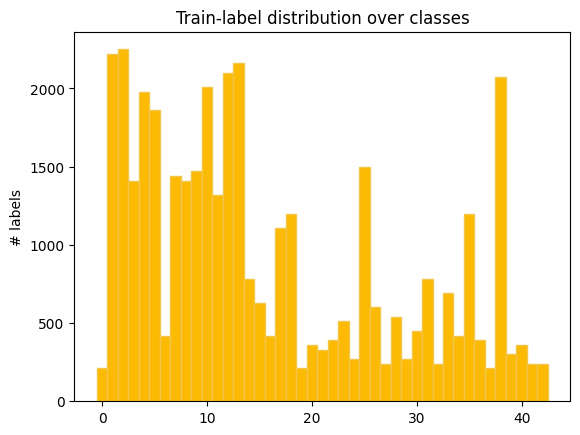

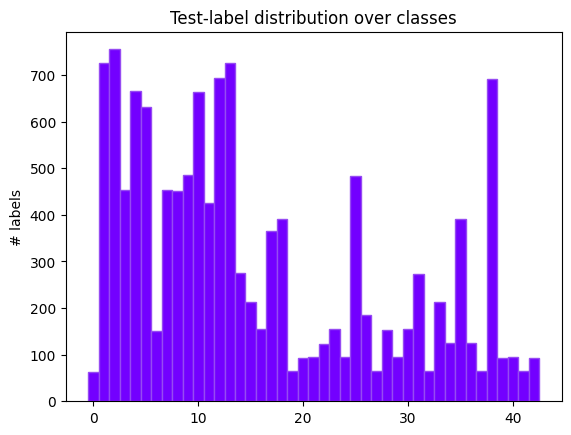

In [35]:
# Plot class histogram to show dataset bias
plt.hist(train_labels, bins=[idx - 0.5 for idx in range(0, max(train_class_names_int)+2)], ec='#f2c64b',color='#fcba03')
plt.title('Train-label distribution over classes')
plt.ylabel('# labels')
plt.show()
plt.hist(test_labels, bins=[idx - 0.5 for idx in range(0, max(train_class_names_int)+2)], ec='#964bf2',color='#7300ff')
plt.title('Test-label distribution over classes')
plt.ylabel('# labels')
plt.show()

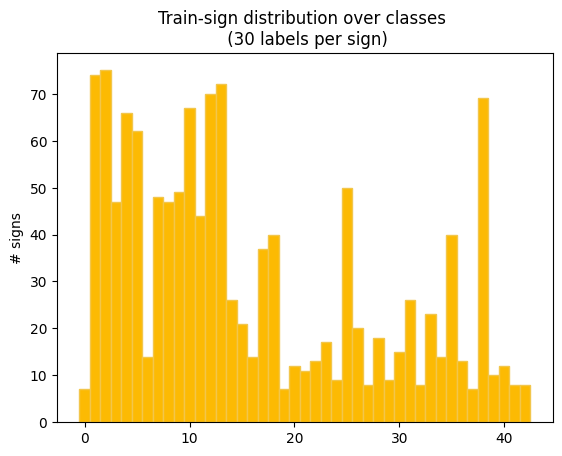

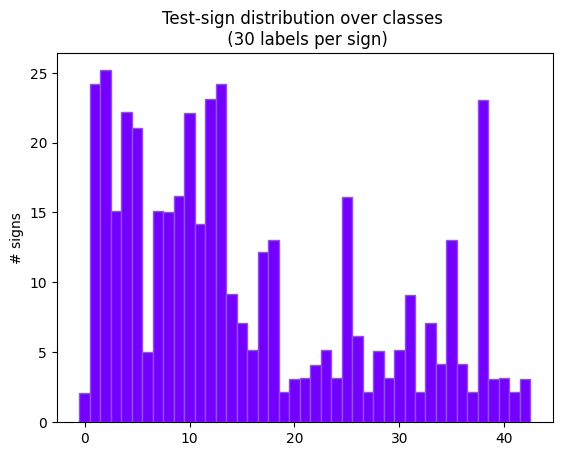

In [36]:
# Plot class histogram for different signs (one sign per 30 labels)
x, bins = np.histogram(train_labels, bins=range(0, max(train_class_names_int)+2))
plt.bar(bins[:-1],x/30,width=1, ec='#f2c64b',color='#fcba03')
plt.title('Train-sign distribution over classes \n (30 labels per sign)')
plt.ylabel('# signs')
plt.show()
x, bins = np.histogram(test_labels, bins=range(0, max(train_class_names_int)+2))
plt.bar(bins[:-1],x/30,width=1,ec='#964bf2',color='#7300ff')
plt.title('Test-sign distribution over classes \n (30 labels per sign)')
plt.ylabel('# signs')
plt.show()

In [41]:
#/////////////////////////////////////// Prediction
# Remember that we had some preprocessing before our training this needs to be repeated here
# Preprocessing as the tensorflow hub models expect images as float inputs [0,1]
if use_augmented_ds:  # To use augmented data run the last cell, augmented images will be saved under ValidationAug directory.
    test_ds_map = test_ds_augmented
else:
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
    test_ds_map = test_ds.map(
        lambda x, y: (normalization_layer(x), y)
    )  # Where x—images, y—labels.

# //////////////////////////////////////// Inference.
predictions = model.predict(test_ds_map)
predictions = np.argmax(predictions, axis=1)

# Mapping the prediction class id based on the folder names
for i in range(0, len(predictions)):
    predictions[i] = int(train_class_names[predictions[i]])

predictions = predictions.tolist()

print("Predictions: ", predictions[:10])
print("Ground truth: ", test_labels[:10])

Predictions:  [0, 0, 0, 1, 1, 0, 1, 0, 3, 0]
Ground truth:  [0 0 0 0 0 0 0 0 0 0]


# Validation
The validation consists of metrics (MAP, accuracy) and tools (wrong detects plot and error matrix)
## Metrics
Accuracy is calculated by:
$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$ <br>

The MAP (Mean Average Precision) is defined as:
$$ MAP = \frac{1}{N} \sum_{i=1}^{N} AP_i$$ <br>

Where:
   - N is the total number of classes.
   - And AP is the Average Precision for the i-th class.



D:\05_GIt\DeepSafety\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\manue\AppData\Local\Temp\ipykernel_2768\158710685.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(average_metrics, ignore_index=True)


    Class  Precision    Recall  Average Precision
0     1.0   0.587302  0.587302           0.346954
1     2.0   0.588175  0.795862           0.479667
2     3.0   0.406389  0.724503           0.469443
3     4.0   0.193498  0.812775           0.690736
4     5.0   0.000000  0.000000           0.939437
5     6.0   0.000000  0.000000           0.941245
6     7.0   0.000000  0.000000           0.886173
7     8.0   0.000000  0.000000           0.924415
8     9.0   0.000000  0.000000           0.724690
9    10.0   0.000000  0.000000           0.871788
10   11.0   0.502041  0.927602           0.630053
11   12.0   0.826698  0.828638           0.138295
12   13.0   0.983631  0.952450           0.310678
13   14.0   0.948617  0.991736           0.196753
14   15.0   0.929078  0.952727           0.281326
15   16.0   0.941704  0.981308           0.539158
16   17.0   0.824242  0.877419           0.493388
17   18.0   0.936464  0.928767           0.275094
18   19.0   0.858006  0.724490           0.636860


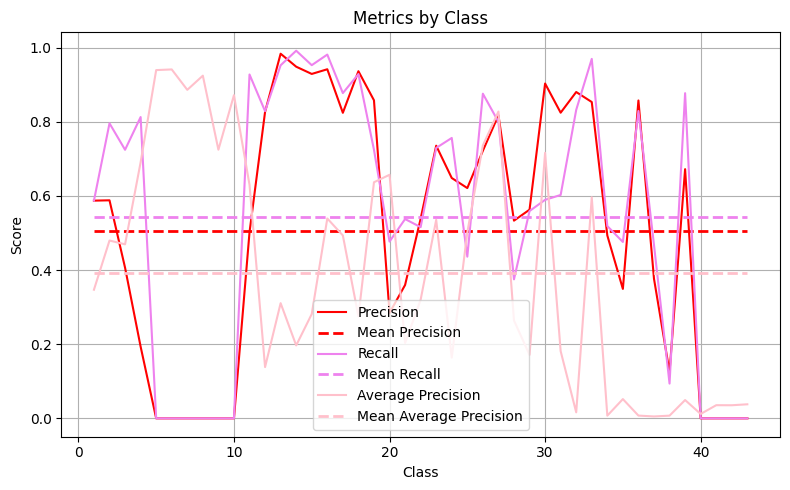

In [42]:
#///////////////////////////////Metrics
# Before a statement over the general performance of the model is made, a more in depth metric evaluation, differentiating the particular classes, is done.
# This also helps to calculate the MAP-Metric later on

# Preprocessing
num_classes = max(train_class_names_int) + 1
# For AP calculation test_labels and precision needs to be converted to multilabel-indicator format
mlb = MultiLabelBinarizer(classes=train_class_names_int)
ap_test_labels = mlb.fit_transform([[label] for label in test_labels])
ap_predictions = mlb.fit_transform([[pred] for pred in predictions])

# First, calculate precision, recall, and average precision for each class
precision = metrics.precision_score(test_labels, predictions, average=None, labels=np.arange(num_classes))
recall = metrics.recall_score(test_labels, predictions, average=None, labels=np.arange(num_classes))
accuracy = metrics.accuracy_score(test_labels, predictions)
average_precision = metrics.average_precision_score(ap_test_labels, ap_predictions, average=None)

# Create a Pandas DataFrame with the metrics for each class
metrics_df = pd.DataFrame({'Class': np.arange(num_classes)+1,
                           'Precision': precision,
                           'Recall': recall,
                           'Average Precision': average_precision})

# Add the average of each metrics over all classes
average_metrics = {
    'Precision': metrics_df['Precision'].mean(),
    'Recall': metrics_df['Recall'].mean(),
    'Average Precision': metrics_df['Average Precision'].mean()
}
metrics_df = metrics_df.append(average_metrics, ignore_index=True)

# Show values
print(metrics_df)
print("===========\n"
      "Main metrics: \n"
      "-----------\n"
      "Accuracy: " + str(accuracy) + "\n"
      "Mean Recall: " + str(average_metrics['Recall']) + "\n"
      "Mean Precision: " + str(average_metrics['Precision']) + "\n"
      "MAP: " + str(average_metrics['Average Precision']) + "\n"
      "===========\n")

# Plot as line plot
class_labels = metrics_df['Class'].values[:-1]  # Exclude the last row (average metrics)
metrics_columns = ['Precision', 'Recall', 'Average Precision']
metrics_color = ['red', 'violet', 'pink']
# metrics_color = ['blue', 'cyan', 'pink']  # If you don't like the more-red spectrum of colors^^
mean_metrics = metrics_df[metrics_columns].iloc[:-1].mean().values
plt.figure(figsize=(8, 5))
for i in range(len(metrics_columns)):
    plt.plot(class_labels, metrics_df[metrics_columns[i]].values[:-1], label=metrics_columns[i], color=metrics_color[i])
    # Mean line:
    plt.plot(class_labels, [mean_metrics[i]] * num_classes, linestyle='--', color=metrics_color[i], linewidth=2, label='Mean '+metrics_columns[i])

# Formatting the line plot
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Metrics by Class')
plt.legend()
plt.grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()


## Plots

To get more information about the detection results, two plotting tools are introduced: A plot of some wrong detected images and the overview of all mismatches in a error matrix. The error matrix in particular differs from the conventional "confusion-matrix" by filtering the correct detects (main diagonal). That way, colors are scaled to the biggest error source and smaller mismatches are more clearly visible.

In [43]:
def format_string2max(text, max_len):
    out_str = ""
    dif = 0
    for i, letter in enumerate(text):
        if ((i-dif) % max_len == 0) and (i != 0):
            out_str += '\n'
        out_str += letter
        if letter == '\n':
            dif += i
    return out_str

In [44]:
# Show wrongly classified data
class_names_df = pd.read_csv("./signnames.csv", index_col="ClassId")
print(f'Test: | Class ID: {predictions[0]} Class Name: {class_names_df["SignName"][predictions[0]]}')
idx_wrong_class = [i for i in range(0, len(predictions)) if predictions[i] != test_labels[i]]

Test: | Class ID: 0 Class Name: Speed limit (20km/h)


C:\Users\manue\AppData\Local\Temp\ipykernel_2768\87217053.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, i + 1)


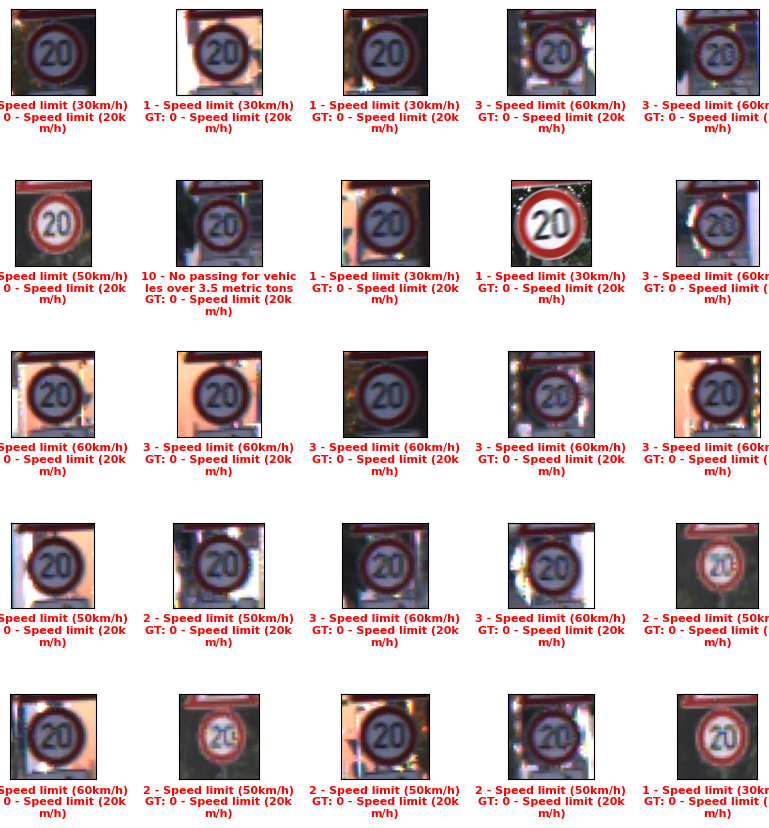

In [45]:
# cut too much data
num_cut = 25
if len(idx_wrong_class)>=num_cut:
    idx_wrong_class_cut = idx_wrong_class[:num_cut]
else:
    idx_wrong_class_cut = idx_wrong_class
numbers_to_display = len(idx_wrong_class_cut)
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10, 10))

for i in range(0, len(idx_wrong_class_cut)):
    idx = idx_wrong_class_cut[i]
    predicted_label = f'{predictions[idx]} - {class_names_df["SignName"][predictions[idx]]}\n' \
                      f'GT: {test_labels[idx]} - {class_names_df["SignName"][test_labels[idx]]}'
    predicted_label = format_string2max(predicted_label, 25)
    plt.grid(False)
    plt.subplot(num_cells, num_cells, i + 1)
    img = mpimg.imread(files[idx])
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    font = {'color': 'green', 'weight': 'normal', 'size': 8} if predictions[idx] == test_labels[idx] \
        else {'color': 'red', 'weight': 'bold', 'size': 8}
    plt.xlabel(predicted_label,  fontdict=font)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.savefig('wrong_detects.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
# Plot error matrix by first calculating all mismatches
num_cls = len(class_names_df)
error_matrix_df = pd.DataFrame(np.zeros((num_cls, num_cls)))
# print(error_matrix_df)
for i in range(0, len(idx_wrong_class)):
    idx = idx_wrong_class[i]
    error_matrix_df.loc[test_labels[idx], predictions[idx]] = error_matrix_df.loc[test_labels[idx], predictions[idx]] + 1
error_matrix_df.columns = class_names_df["SignName"].tolist()
error_matrix_df.index = class_names_df["SignName"].tolist()

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

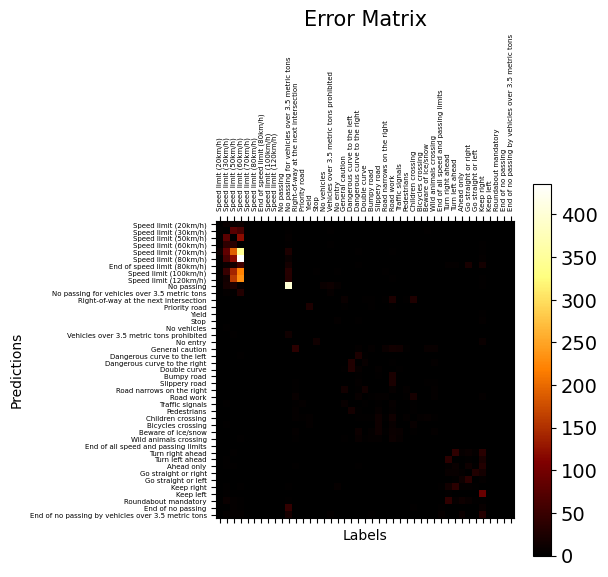

Max error count: 436.0    Min error count: 0.0


In [47]:
# rescale for better visualisation
fig = plt.gcf()
plt.figure(figsize=(10, 10))
plt.matshow(error_matrix_df, cmap='afmhot')
plt.xticks(range(len(class_names_df)), class_names_df["SignName"].tolist(), fontsize=5, rotation=90)
plt.yticks(range(len(class_names_df)), class_names_df["SignName"].tolist(), fontsize=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Error Matrix', fontsize=15);
plt.ylabel('Predictions')
plt.xlabel('Labels')
plt.savefig('error_matrix.jpg', dpi=300, bbox_inches='tight')
plt.show()
print("Max error count: " + str(error_matrix_df.max().max()) + "    Min error count: " + str(error_matrix_df.min().min()))

## Data augmentation & Validation batch

After having a detailed look on the prediction results, it's clear that there needs to be a better training and validation set. The detection errors between signs of the same shape and color (e.g. class 0 - 10 and 33 - 40) is extremely high. While a longer training might result in a better outcome, the risk of overfitting also rises. To achive a more robust detection model,
- the model itself is improved (Different feature extractor, pooling layer) -> See kickstart.py
- the validation set is supplemented by new pictures (Meta and internet) to improve biased class imbalance
- the trainings set is augmented by rotated, shifted and sheared versions of the images
- same is done for the validation batch

In [37]:
#///////////////////////////Augmentation
# For more robust results a ImageDataGenerator is used: (See kickstart.py) Credit for idea: https://www.kaggle.com/code/shivank856/gtsrb-cnn-98-test-accuracy
use_augmented_ds = True
aug = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        zoom_range=0.15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        horizontal_flip=False,  # Not allowed as a flipped sign has a different meaning!
        vertical_flip=False,  # Same here...
        fill_mode="nearest")

test_ds_augmented = aug.flow_from_directory(
    test_data_root,
    seed=123,
    # save_to_dir='./dataset/ValidationAug',
    save_to_dir='./Validation/ValidationAug',
    target_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 12802 images belonging to 43 classes.
